# MNIST classification with stabilized ICA and multinomial logistic regression   

In this jupyter notebook we illustrate the integration of stabilized-ica into standard scikit-learn Machine Learning pipelines. We apply stabilized-ica and fit a multinomial logistic regression on the MNIST digits classification task.

**Note :** Applying ICA and its stabilized-version to images simply means that we consider each image to be a linear combination of independent basis images (i.e ICA sources). These basis images contain sparse and local patterns linked to edges and curves.

In [1]:
%load_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
import numpy as np

## 0. Load MNIST data

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

We download the MNIST data set from the open platform [openml.org](https://www.openml.org/) using the tool of scikit-learn [sklearn.datasets.fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html). It contains a dataset of 70000 samples and 784 features which correspond to the grey level of each pixel (i.e 28x28 flattened images). Each image is associated with a class label (from '0' to '9') which corresponds to the handwritten digit that it contains.

In [3]:
# Load data from https://www.openml.org/d/554
start = time.time()
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
end = time.time()

minutes, seconds = divmod(end - start, 60)
print("Loading time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

Loading time (min): 00:23.27


We split the dataset into a training set of 60000 samples and a test set of 10000 samples. 

In [4]:
random_state = check_random_state(0) #fix the seed for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.astype('int'),
                                                    test_size=1/7.0,
                                                    shuffle=True,
                                                    random_state=random_state)

Finally, we can check that the 10 classes are roughly equally distributed in the training set as well as in the test set.

Text(0.5, 1.0, 'Frequency of classes - Test data')

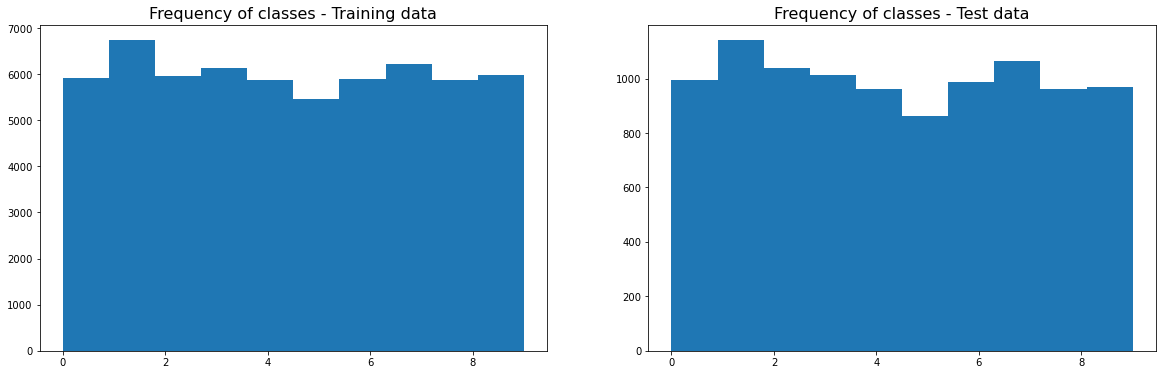

In [5]:
fig, axes = plt.subplots(1,2, figsize=(20, 6))
axes[0].hist(y_train);
axes[0].set_title('Frequency of classes - Training data', fontsize=16)

axes[1].hist(y_test);
axes[1].set_title('Frequency of classes - Test data', fontsize=16)

## 1. Select the number of ICA components to extract

In [6]:
from sica.base import MSTD, StabilizedICA
from sklearn.decomposition import PCA

Here we want to get more insights about the appropriate number of ICA components we should select. Unfortunatly, there is no real consensus about how to select such a number. We can still run different tests:
* Decompose the data set with PCA to estimate its intrinsic dimension (i.e what is the number of PCA components needed to retain 90% of the variance ?).
* Study the stability of ICA components for different orders of decomposition (we want to find a trade-off between a sufficiently large number of components and a satisfying overall stability of the components).
* Test the quality of the reconstruction of several unseen images with the ICA features (for different order of decomposition).

**Note 1:** We perform these tests on the training set alone to avoid any risk of data leakage.   

**Note 2:** In the following we will center the expression of each pixel to avoid PCA and ICA capturing a component which simply separates the background pixels (i.e those on the side of the images) from the foreground pixels (i.e those in the center of the images).

Text(0, 0.5, 'Cumulative explained variance')

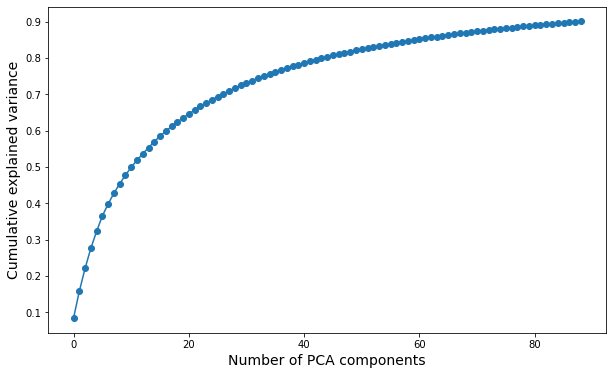

In [7]:
pca = PCA(n_components=0.9).fit((X_train-X_train.mean(axis=0)).T)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
ax.set_xlabel("Number of PCA components", fontsize=14)
ax.set_ylabel("Cumulative explained variance", fontsize=14)

  0%|          | 0/96 [00:00<?, ?it/s]

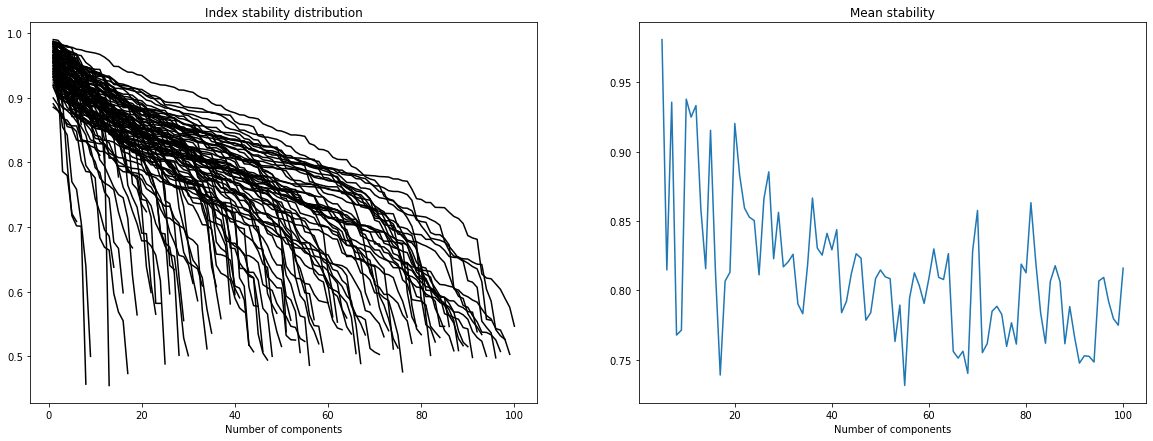

In [8]:
MSTD(X_train - X_train.mean(axis=0), m = 5, M = 100, step = 1, n_runs=50)

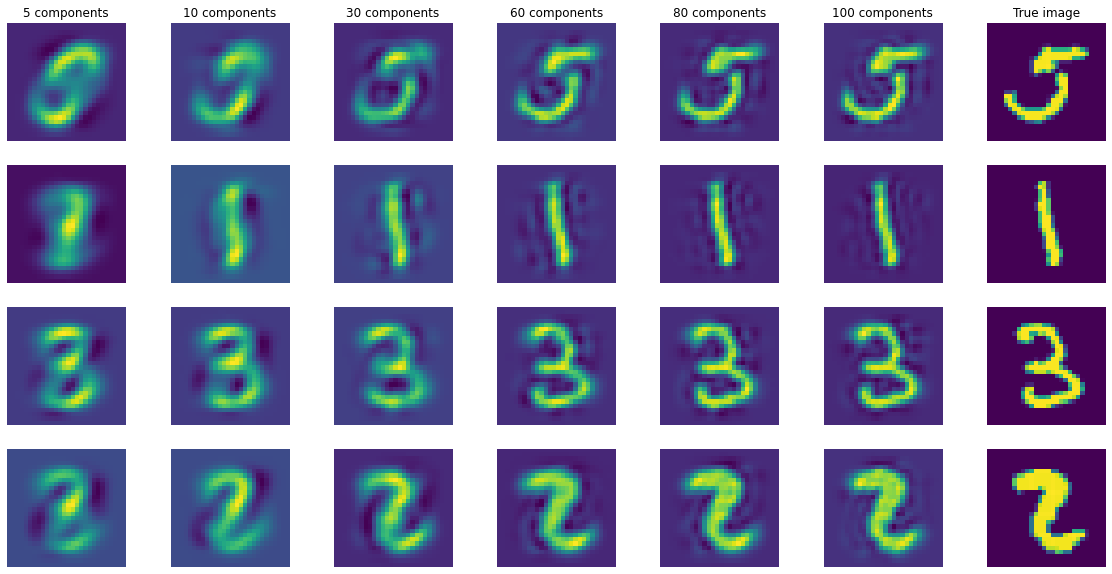

In [9]:
#We first remove three images to test their reconstruction later with the ICA features extracted from
#the remaining training data.
X_new_train, X_new_test = train_test_split(X_train, shuffle=True, test_size = 10, stratify = y_train)

#Here, we apply PCA with the maximum number of components to avoid repeating this step for each ICA decomposition
X_w = PCA(n_components=100).fit_transform((X_new_train-X_new_train.mean(axis=0)).T).T

fig, axes = plt.subplots(4, 7, figsize=(20,10))

for j, n in enumerate([5, 10, 30, 60, 80, 100]):
    sICA = StabilizedICA(n_components=n, n_runs=100, plot=False, n_jobs=-1)
    sICA.fit(X_w[:n, :])
    A = sICA.transform(X_new_test - X_new_train.mean(axis=0))
    for i in range(4):
        axes[i, j].imshow((np.dot(A[i, :], sICA.S_) + X_new_train.mean(axis=0)).reshape((28,28)))
        axes[i, j].axis("off")
        if i==0:
            axes[i, j].set_title(str(n) + " components")

for i in range(4):
    axes[i, -1].imshow(X_new_test[i, :].reshape((28,28)))
    axes[i, -1].axis("off")
    if i==0:
        axes[i, -1].set_title("True image")

Even with these different tests it is still difficult to select one single optimal number of independent sources. However we can make some interesting observations:
* With PCA we observe that 60 to 80 components are enough to retain 80% to 90% of the variance.
* 60 to 80 components give fairly accurate reconstruction of the original images (meaning that not so much information has been lost with the ICA decomposition).
* Looking at the stability plots we observe that, though the average stability decreases with the number of components it seems to slown down starting from ~50 components (meaning that the ratio of stable components to unstable ones does not change too much with the order of decomposition). 

In the following we will use **60 independent components** since it seems to be sufficiently large to capture relevant information and it is not too much affected by very unstable components.

## 2. Build, train and test a classification pipeline

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report

Here we build a very simple Machine Learning classification pipeline with four steps:
* 1. Center the expression of each pixel (remove a component which separates background from foreground)
* 2. Apply stabilized ICA to reduce dimensionnality
* 3. Standardize the transformed data set (mainly useful for feature importances analysis)
* 4. Apply multinomial logistic regression

In [11]:
pipe = Pipeline(steps=[('scaler', StandardScaler(with_std=False)),
                       ('sICA' , StabilizedICA(n_components=60, n_runs=100)),
                       ('scaler_bis', StandardScaler()),
                       ('logistic', LogisticRegression(max_iter=2000))
                      ]
                )

start = time.time()
pipe.fit(X_train, y_train)
end = time.time()

minutes, seconds = divmod(end - start, 60)
print("Training time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))         

Training time (min): 00:31.42


For each class we display the precision, the recall and the F1-score associated to the binary task one class vs all. We also compute their averages over the different classes (i.e macro-average).

In [12]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['class ' + str(i) for i in pipe['logistic'].classes_]))

              precision    recall  f1-score   support

     class 0       0.96      0.97      0.96       996
     class 1       0.95      0.97      0.96      1141
     class 2       0.90      0.88      0.89      1040
     class 3       0.91      0.87      0.89      1013
     class 4       0.88      0.92      0.90       962
     class 5       0.86      0.84      0.85       863
     class 6       0.94      0.95      0.94       989
     class 7       0.92      0.92      0.92      1064
     class 8       0.87      0.87      0.87       963
     class 9       0.86      0.87      0.87       969

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [13]:
print("Accuracy micro-average: ", pipe.score(X_test, y_test))

Accuracy micro-average:  0.9078


We obtain here a satisfying accuracy which is very close to the one we obtain by fitting a logistic regression on the 784 features. But with stabilized-ica as a preprocessing step the running time is much lower.

**Note :** This performance is still significantly lower than the ones obtained with non-linear models and convolutional neural networks (see [here](http://yann.lecun.com/exdb/mnist/) for a benchmark). 

## 3. Use stabilized-ica to interpret the classifier

Multinomial logistic regression gives us a natural way of higlihting the important features for the classification by studying the feature weights associated to each class.   

### 3.1 Important features for the 0 digit

We can select the most important ICA features for the 0 class (with negative and positive weights) and display their associate ICA sources.

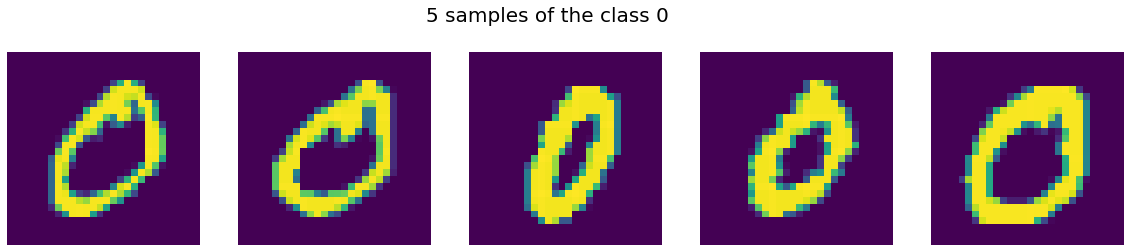

In [14]:
fig, axes = plt.subplots(1,5, figsize = (20, 10))
fig.suptitle("5 samples of the class 0", fontsize=20, y=0.7)

for i in range(5):
    axes[i].imshow(X[y=='0'][i, :].reshape((28,28)))
    axes[i].axis("off")

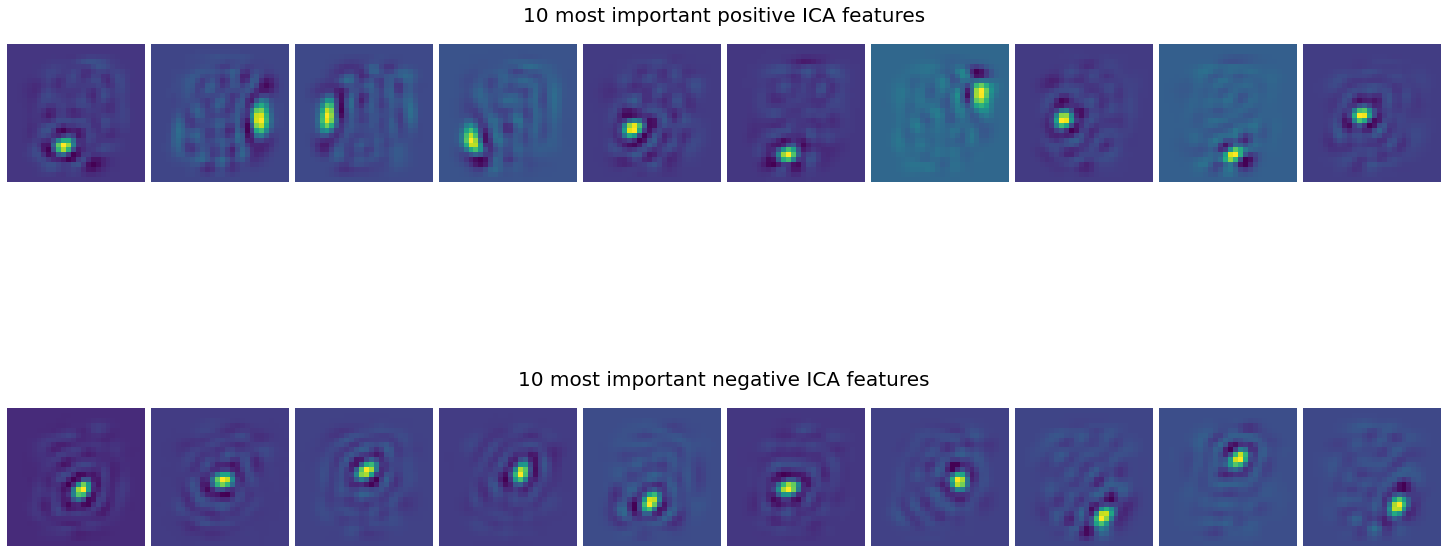

In [15]:
fig = plt.figure(constrained_layout=True, figsize = (20, 10))
subfigs = fig.subfigures(2, 1)

subfigs[0].suptitle("10 most important positive ICA features", fontsize=20, y=0.8)
axs = subfigs[0].subplots(1, 10)
for i, index in enumerate(np.flip(np.argsort(pipe['logistic'].coef_[0,:]))[:10]):
    axs[i].imshow(pipe['sICA'].S_[index, :].reshape((28,28)))
    axs[i].axis("off")
    
subfigs[1].suptitle("10 most important negative ICA features", fontsize=20, y=0.8)
axs = subfigs[1].subplots(1, 10)
for i, index in enumerate(np.argsort(pipe['logistic'].coef_[0,:])[:10]):
    axs[i].imshow(pipe['sICA'].S_[index, :].reshape((28,28)))
    axs[i].axis("off")

Here we can roughly see that the most important positive features highlight the edges of the circles forming the zero digits whereas the most important negative features rather focus on the center of the circle

### 3.2 Weighted aggregation of the ICA sources

For each digit we can aggregate the ICA sources weighting them with the coefficients of the logistic regression. It may give us an idea of the areas of the image the algorithm considers for predicting each class. 

**Note :** In order to improve the visualization we clip each aggregated image to [-std, +std] so that the extreme pixels are highlighted.

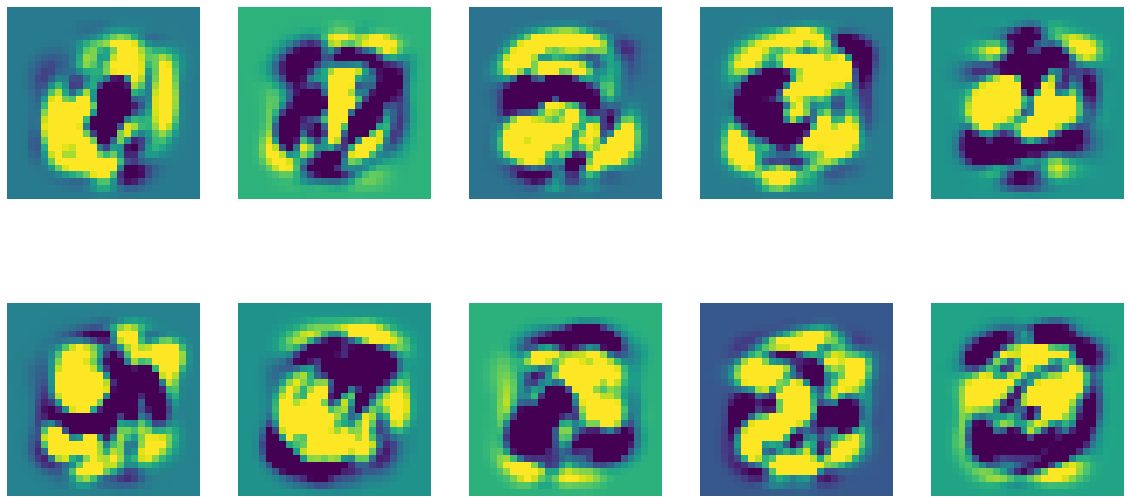

In [16]:
fig , axes = plt.subplots(2, 5, figsize=(20,10))
axes = axes.flatten()

for i in range(10):
    img = (pipe['sICA'].S_*pipe['logistic'].coef_[i,:].reshape(-1,1)).sum(axis=0)
    axes[i].imshow(np.clip(img, -img.std(), img.std()).reshape((28,28)))
    axes[i].axis("off")